# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Mapping Analysis

Author: Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- What neighborhood has the most complaints?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

numpy     : 1.23.4
pandas    : 1.5.1
geopandas : 0.12.1
geoplot   : not installed
fiona     : 1.8.22
matplotlib: 3.6.2
seaborn   : 0.12.1



# Reading In Data

## NYC 311 Street Flooding Complaints

In [3]:
# list items in data folder
%ls data/

README.md                               streets-clipped.gpkg
street-flooding-complaints-cleaned.csv  streets.gpkg
street-flooding-complaints.csv          water-main-breaks.csv


In [4]:
# read data as a dataframe
path = 'data/street-flooding-complaints-cleaned.csv'
df = pd.read_csv(path, low_memory=False)

# previewing first five rows in data
print(f'shape of data: {df.shape}')
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,incident_zip,city,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location,incident_address,street_name,bbl
0,34783066,2016-11-15T09:27:00.000,2016-11-15T10:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,10301.0,STATEN ISLAND,958594.0,170855.0,40.635597,-74.092438,"{'latitude': '40.635596930697716', 'longitude'...",NaN,NaN,NaN
1,36178846,2017-05-13T14:41:00.000,2017-11-08T11:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),32 AVE,78 ST,INTERSECTION,...,11370.0,East Elmhurst,1014871.0,215198.0,40.757292,-73.889472,"{'latitude': '40.75729226742685', 'longitude':...",NaN,NaN,NaN
2,31360389,2015-08-21T05:46:00.000,2015-08-26T10:27:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),110 AVE,110 RD,ADDRESS,...,11433.0,JAMAICA,1043288.0,192114.0,40.693788,-73.787102,"{'latitude': '40.69378840426638', 'longitude':...",110-07 164 PLACE,164 PLACE,4.101930e+09
3,32686230,2016-02-15T13:10:00.000,2016-02-16T14:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ALDUS ST,HOE AVE,INTERSECTION,...,10459.0,BRONX,1014578.0,239190.0,40.823145,-73.890421,"{'latitude': '40.82314481234778', 'longitude':...",NaN,NaN,NaN
4,41495135,2019-01-23T11:59:00.000,2019-01-28T13:05:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),102 ST,DEAD END,ADDRESS,...,11414.0,HOWARD BEACH,1031172.0,179312.0,40.658722,-73.830883,"{'latitude': '40.65872239939313', 'longitude':...",102-20 160 AVENUE,160 AVENUE,4.142340e+09


In [5]:
# column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24816 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   cross_street_1                  21821 non-null  object 
 8   cross_street_2                  21816 non-null  object 
 9   address_type                    24817 non-null  object 
 10  status                          24817 non-null  object 
 11  resolution_description          24813 non-null  object 
 12  resolution_action_updated_date  

## NYC Boroughs

In [6]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/resource/gthc-hcne.geojson'
borough_gdf = gpd.read_file(path).to_crs(2263)

# previewing first five rows in data
print(f'shape of data: {borough_gdf.shape}')
borough_gdf.head()

shape of data: (5, 5)


,borocode,boroname,shape_area,shape_leng,geometry
0,3,Brooklyn,1934142842.48,728150.705111,"MULTIPOLYGON (((1022227.393 152028.338, 102207..."
1,5,Staten Island,1623618684.31,325910.306061,"MULTIPOLYGON (((970217.085 145643.397, 970227...."
2,1,Manhattan,636645571.613,360056.730857,"MULTIPOLYGON (((981219.022 188655.462, 980940...."
3,2,Bronx,1187174772.32,463180.578878,"MULTIPOLYGON (((1012821.787 229228.479, 101278..."
4,4,Queens,3041418003.6,888197.010944,"MULTIPOLYGON (((1032452.096 154469.461, 103245..."


In [7]:
# column info
borough_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   borocode    5 non-null      object  
 1   boroname    5 non-null      object  
 2   shape_area  5 non-null      object  
 3   shape_leng  5 non-null      object  
 4   geometry    5 non-null      geometry
dtypes: geometry(1), object(4)
memory usage: 328.0+ bytes


## Neighborhood Tabulation Areas (NTAs)

In [8]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson'
nta_gdf = gpd.read_file(url).to_crs(epsg=2263)

# previewing first five rows in data
print(f'shape of data: {nta_gdf.shape}')
nta_gdf.head()

shape of data: (262, 12)


,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321204.8204,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5653122,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299..."
1,28854314.555,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0267744,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((995851.880 203199.535, 995969...."
2,15208960.44,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2804159,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((998047.189 196303.521, 998157...."
3,52266209.4439,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773814,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((1005302.485 199455.944, 100530..."
4,9982321.73877,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.506134,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((986737.292 194249.956, 986678...."


In [9]:
# column info
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   shape_area  262 non-null    object  
 1   ntaname     262 non-null    object  
 2   cdtaname    262 non-null    object  
 3   shape_leng  262 non-null    object  
 4   boroname    262 non-null    object  
 5   ntatype     262 non-null    object  
 6   nta2020     262 non-null    object  
 7   borocode    262 non-null    object  
 8   countyfips  262 non-null    object  
 9   ntaabbrev   262 non-null    object  
 10  cdta2020    262 non-null    object  
 11  geometry    262 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 24.7+ KB


# Data Wrangling

In [10]:
# format datetime columns
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['year'] = df['created_date'].dt.year

# examine columns
cols = ['created_date', 'closed_date', 'year']
df.loc[:, cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  24817 non-null  datetime64[ns]
 1   closed_date   24816 non-null  datetime64[ns]
 2   year          24817 non-null  int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 581.8 KB


In [11]:
# create new columns in nta dataframe
nta_gdf['ntaname_boro'] = nta_gdf['ntaname'] + ', ' + nta_gdf['boroname']
nta_gdf['shape_area'] = nta_gdf['shape_area'].astype(float)
nta_gdf['shape_leng'] = nta_gdf['shape_leng'].astype(float)
nta_gdf['shape_area_sq_mi'] = nta_gdf['shape_area'] / 27878400

# examine new columns
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   shape_area        262 non-null    float64 
 1   ntaname           262 non-null    object  
 2   cdtaname          262 non-null    object  
 3   shape_leng        262 non-null    float64 
 4   boroname          262 non-null    object  
 5   ntatype           262 non-null    object  
 6   nta2020           262 non-null    object  
 7   borocode          262 non-null    object  
 8   countyfips        262 non-null    object  
 9   ntaabbrev         262 non-null    object  
 10  cdta2020          262 non-null    object  
 11  geometry          262 non-null    geometry
 12  ntaname_boro      262 non-null    object  
 13  shape_area_sq_mi  262 non-null    float64 
dtypes: float64(3), geometry(1), object(10)
memory usage: 28.8+ KB


In [12]:
# specify CRS, these coordinates are in 2263 from the documentation
crs = 2263

# generate geometry from x, y points
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# create geodataframe
gdf = gpd.GeoDataFrame(
    df,
    geometry=geometry,
    crs=crs
)

# preview data
print(f'shape of data: {gdf.shape}')
gdf.iloc[:5, -5:]

shape of data: (24817, 29)


,incident_address,street_name,bbl,year,geometry
0,NaN,NaN,NaN,2016,POINT (958594.000 170855.000)
1,NaN,NaN,NaN,2017,POINT (1014871.000 215198.000)
2,110-07 164 PLACE,164 PLACE,4.101930e+09,2015,POINT (1043288.000 192114.000)
3,NaN,NaN,NaN,2016,POINT (1014578.000 239190.000)
4,102-20 160 AVENUE,160 AVENUE,4.142340e+09,2019,POINT (1031172.000 179312.000)


In [13]:
# confirm crs
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot: >

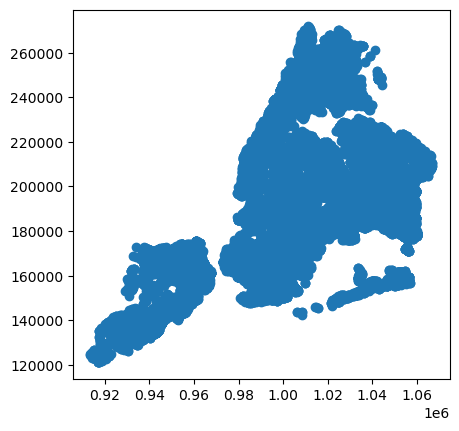

In [14]:
# sanity check map
gdf.plot()

## Spatial Join Neighborhood Tabulation Areas (NTAs) Information to Complaints

In [15]:
# spatial join nta information to points
gdf_merged = gpd.sjoin(
    gdf,
    nta_gdf,
    how="inner",
    predicate='within'
)

# drop right index column and reset gdf index
gdf_merged = (
    gdf_merged
    .drop(columns=['index_right'])
    .reset_index(drop=True)
)

# sanity checks
print(f'shape of data: {gdf_merged.shape}')
print(f'count dropped rows: {gdf.shape[0] - gdf_merged.shape[0]}')
print(f"unique_key unique: {gdf_merged['unique_key'].is_unique}.")
print(f'{gdf_merged.crs}')

# preview data
gdf_merged.head()

shape of data: (24814, 42)
count dropped rows: 3
unique_key unique: True.
epsg:2263


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,cross_street_1,cross_street_2,address_type,...,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,ntaname_boro,shape_area_sq_mi
0,34783066,2016-11-15 09:27:00,2016-11-15 10:05:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,NaN,INTERSECTION,...,31943.524638,Staten Island,0,SI0101,5,085,StGrg,SI01,"St. George-New Brighton, Staten Island",0.950837
1,16585559,2010-05-04 09:20:00,2010-05-08 09:00:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,31943.524638,Staten Island,0,SI0101,5,085,StGrg,SI01,"St. George-New Brighton, Staten Island",0.950837
2,18255249,2010-07-13 13:20:00,2010-07-13 15:10:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,31943.524638,Staten Island,0,SI0101,5,085,StGrg,SI01,"St. George-New Brighton, Staten Island",0.950837
3,18380954,2010-07-30 11:08:00,2010-07-30 11:20:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),DANIEL LOW TER,BEND,ADDRESS,...,31943.524638,Staten Island,0,SI0101,5,085,StGrg,SI01,"St. George-New Brighton, Staten Island",0.950837
4,18449016,2010-08-09 13:49:00,2010-08-09 14:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),ST PETER'S PL,BEND,ADDRESS,...,31943.524638,Staten Island,0,SI0101,5,085,StGrg,SI01,"St. George-New Brighton, Staten Island",0.950837


In [16]:
# column info
gdf_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24814 entries, 0 to 24813
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      24814 non-null  int64         
 1   created_date                    24814 non-null  datetime64[ns]
 2   closed_date                     24813 non-null  datetime64[ns]
 3   agency                          24814 non-null  object        
 4   agency_name                     24814 non-null  object        
 5   complaint_type                  24814 non-null  object        
 6   descriptor                      24814 non-null  object        
 7   cross_street_1                  21821 non-null  object        
 8   cross_street_2                  21816 non-null  object        
 9   address_type                    24814 non-null  object        
 10  status                          24814 non-null  object        

In [17]:
# examine two borough columns, check borough comparison between complaint and nta
condition = (gdf_merged['borough'].str.title() != gdf_merged['boroname'].str.title())
count = gdf_merged.loc[condition].shape[0]

print(f"count of borough names that don't reconcile: {count:,}")

count of borough names that don't reconcile: 65


In [18]:
# examine these mismatches, 311 vs. NTA borough name
(gdf_merged
 .loc[condition]
 .groupby(by=['borough', 'boroname'])['unique_key']
 .count()
)

borough      boroname
BROOKLYN     Queens      30
MANHATTAN    Bronx        5
QUEENS       Brooklyn    25
Unspecified  Brooklyn     1
             Queens       4
Name: unique_key, dtype: int64

In [19]:
# drop borough column from 311 dataset, we assume NTA borough name is closer to actual point location
criteria = gdf_merged.columns.isin(['borough'])

# use this pandas style so we can run this cell again if needed
gdf_merged = gdf_merged.loc[:, gdf_merged.columns[~criteria]]

print(f'shape of data: {gdf_merged.shape}\n')
gdf_merged.info()

shape of data: (24814, 41)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24814 entries, 0 to 24813
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      24814 non-null  int64         
 1   created_date                    24814 non-null  datetime64[ns]
 2   closed_date                     24813 non-null  datetime64[ns]
 3   agency                          24814 non-null  object        
 4   agency_name                     24814 non-null  object        
 5   complaint_type                  24814 non-null  object        
 6   descriptor                      24814 non-null  object        
 7   cross_street_1                  21821 non-null  object        
 8   cross_street_2                  21816 non-null  object        
 9   address_type                    24814 non-null  object        
 10  status                          24

# Creating Maps

## Hexbin Maps of Counts of Complaints

In [20]:
# identify max bounds of hexbin gridsize = 30
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
)

plt.close()
print(f'max value of array: {hb.get_array().max()}')

max value of array: 423.0


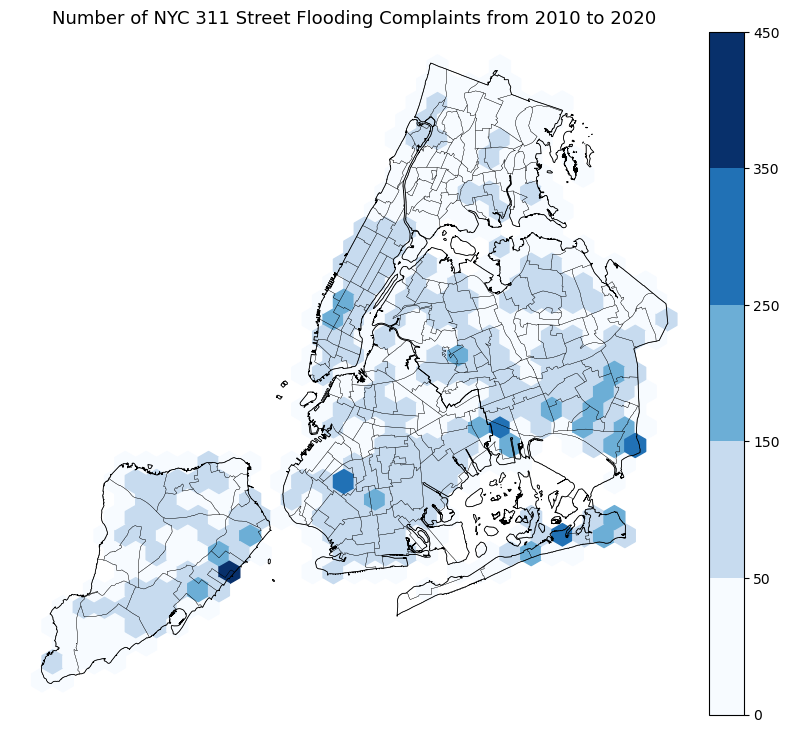

In [21]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 50, 150, 250, 350, 450], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

label = "Number of NYC 311 Street Flooding Complaints from 2010 to 2020"
ax.set_title(label, fontsize=13)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

In [22]:
# identify max bounds of hexbin gridsize = 50
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
)

plt.close()
print(f'max value of array: {hb.get_array().max()}')

max value of array: 318.0


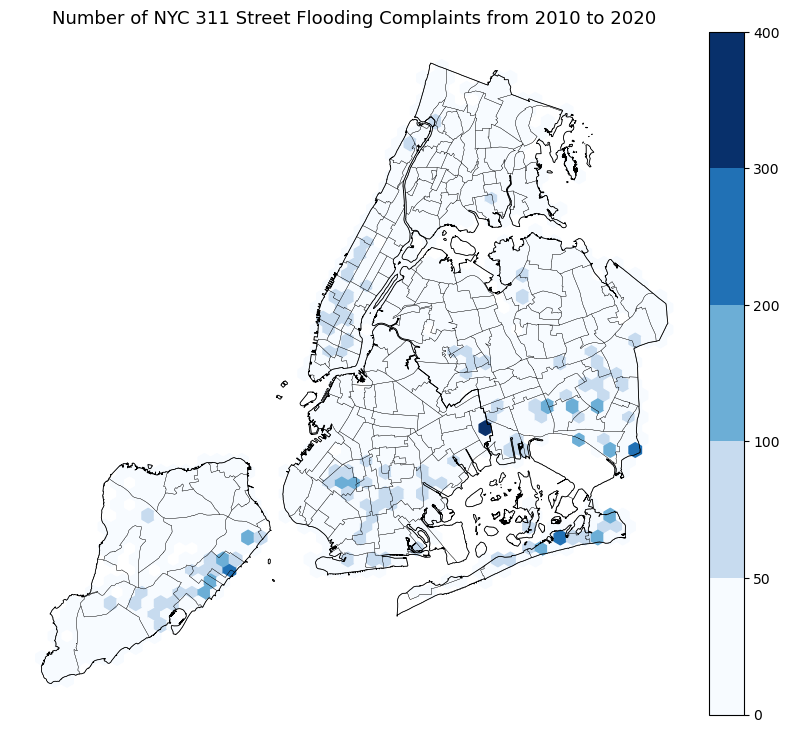

In [23]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

label = "Number of NYC 311 Street Flooding Complaints from 2010 to 2020"
ax.set_title(label, fontsize=13)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

### Counts By Borough

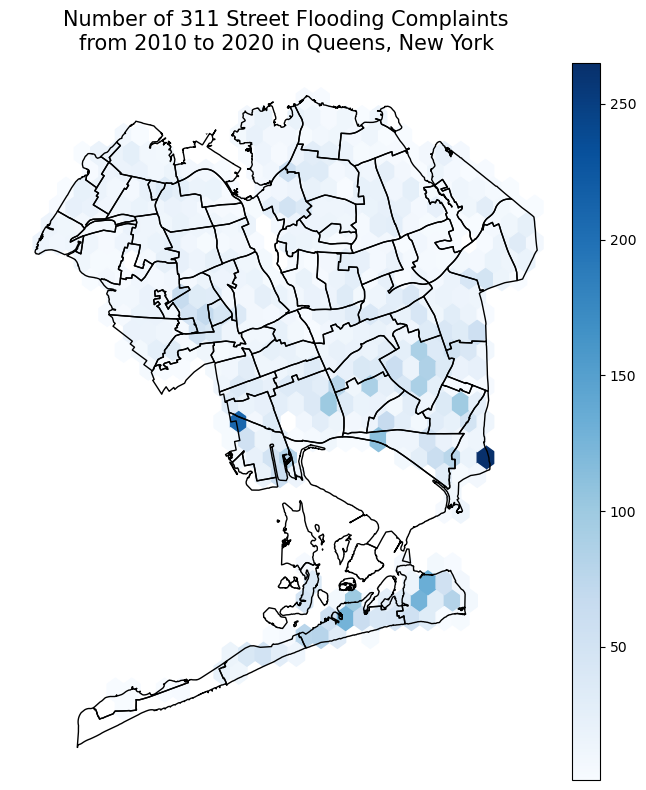

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Queens'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boroname'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Number of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Queens, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

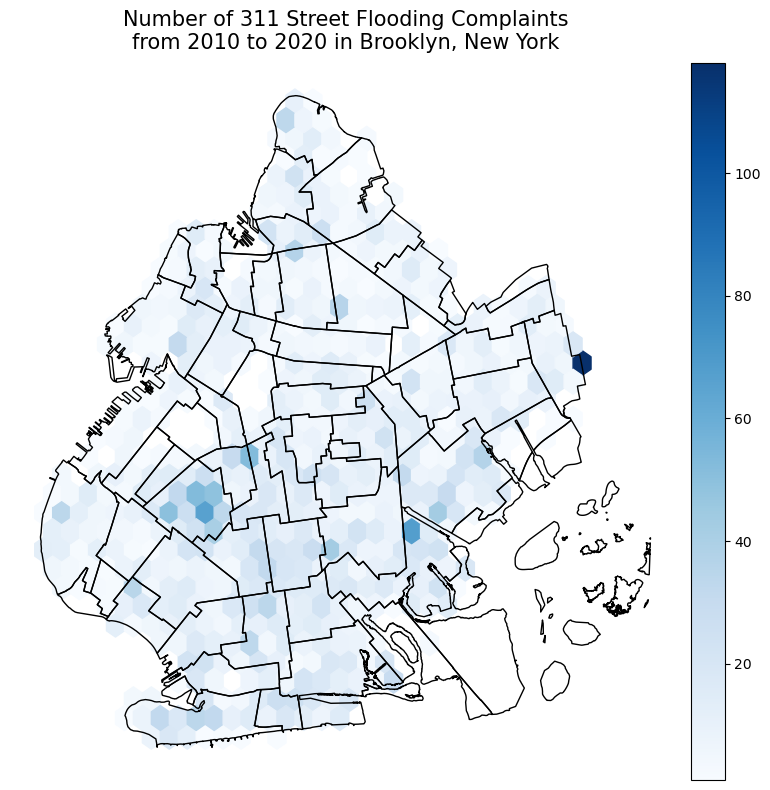

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Brooklyn'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boroname'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)
 
label = 'Number of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Brooklyn, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

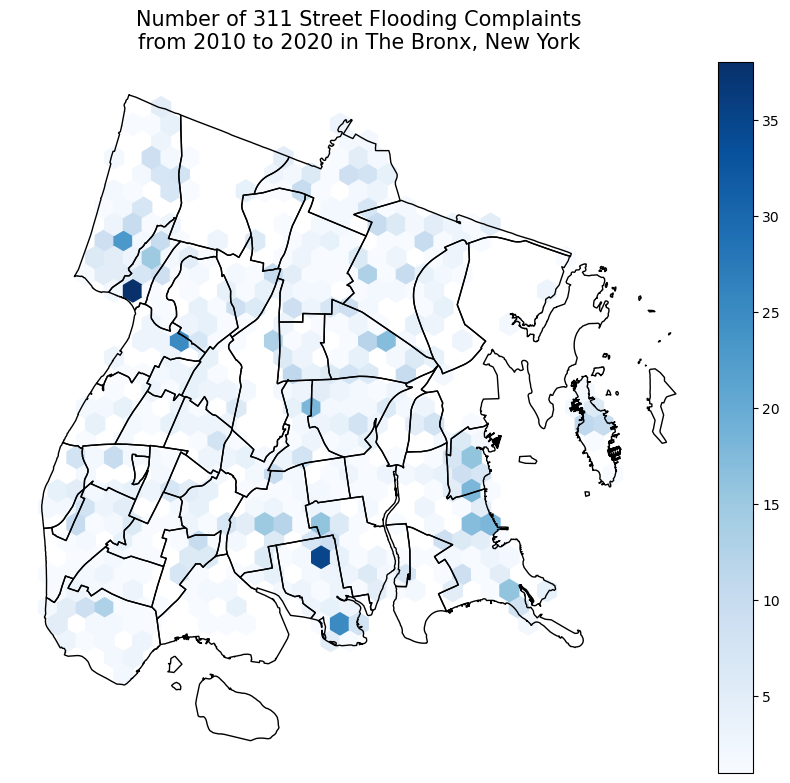

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Bronx'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'x_coordinate_state_plane'],
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boroname'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Number of 311 Street Flooding Complaints\nfrom 2010 to 2020 in The Bronx, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

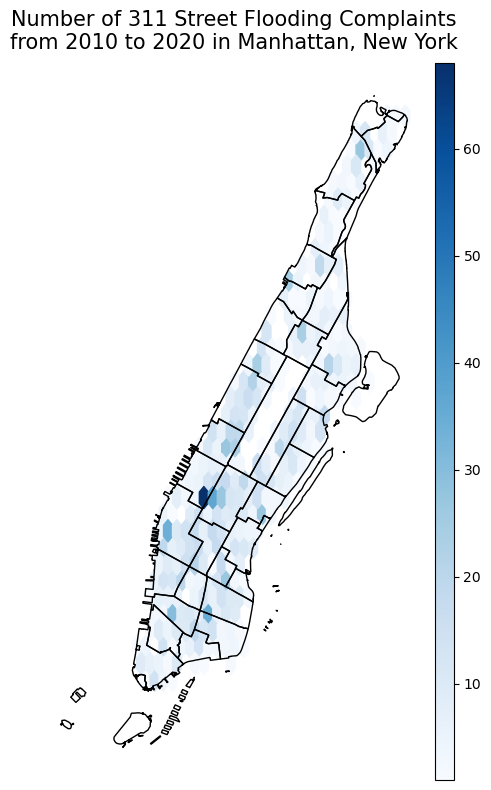

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Manhattan'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boroname'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)

label = 'Number of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Manhattan, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

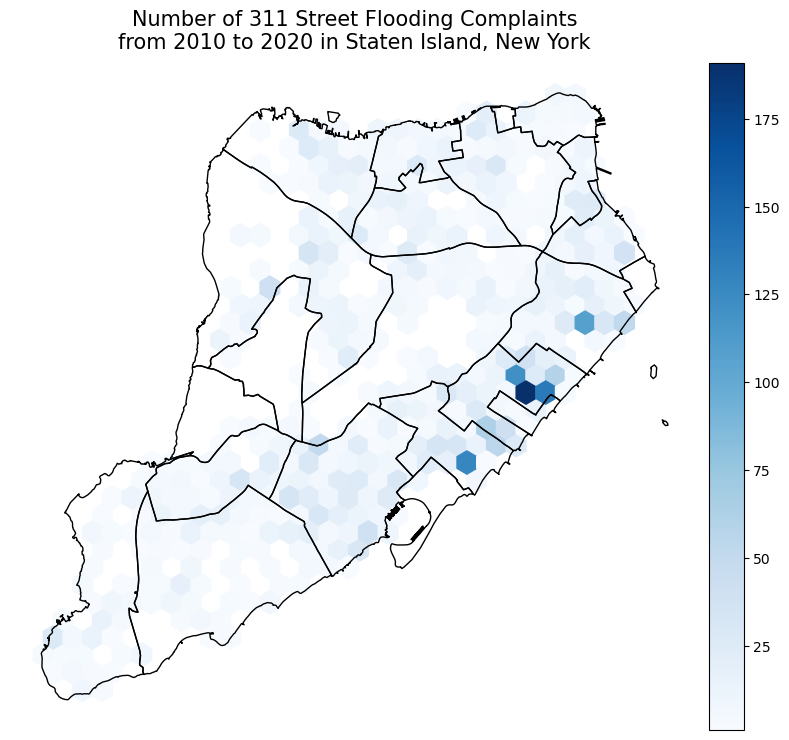

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

boro_name = 'Staten Island'
hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boroname'] == boro_name, 'y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf['boroname'] == boro_name]
 .plot(facecolor="none", edgecolor="black", ax=ax)
)


label = 'Number of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Staten Island, New York'
ax.set_title(label, fontsize=15, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**

## Counts by Neighborhood Tabulation Areas (NTA)

In [29]:
# group complaints by NTA
grouped_gdf = (
    gdf_merged
    .groupby(by='ntaname_boro')['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

# merge nta complaint counts with nta shapefile
nta_gdf_counts = nta_gdf.merge(
    grouped_gdf,
    on='ntaname_boro'
)

# get count per sq mi
area = nta_gdf_counts['shape_area_sq_mi'].replace(0, np.nan)
nta_gdf_counts['count_sq_mi'] = round(nta_gdf_counts['count'] / area, 2)

print(f'shape of data: {nta_gdf_counts.shape}\n')
nta_gdf_counts.head()

shape of data: (243, 16)



,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,ntaname_boro,shape_area_sq_mi,count,count_sq_mi
0,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,103,81.30
1,2.885431e+07,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026774,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((995851.880 203199.535, 995969....","Williamsburg, Brooklyn",1.035006,74,71.50
2,1.520896e+07,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280416,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((998047.189 196303.521, 998157....","South Williamsburg, Brooklyn",0.545546,99,181.47
3,5.226621e+07,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773814,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((1005302.485 199455.944, 100530...","East Williamsburg, Brooklyn",1.874792,76,40.54
4,9.982322e+06,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.506134,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((986737.292 194249.956, 986678....","Brooklyn Heights, Brooklyn",0.358067,23,64.23


In [30]:
# summary stats of nta counts
nta_gdf_counts.loc[:, ['count', 'count_sq_mi']].describe()

,count,count_sq_mi
count,243.000000,243.000000
mean,102.115226,83.142551
std,126.482560,71.246100
min,1.000000,0.510000
25%,21.000000,37.495000
50%,68.000000,69.160000
75%,133.000000,111.005000
max,913.000000,510.940000


**Table xx:** Highest Count of 311 Street Flooding Complaints by Neighborhood Tabulation Area (NTA) in New York City.

In [31]:
# preview count sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'count', 'count_sq_mi', 'shape_area_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

,ntaname_boro,count,count_sq_mi,area_sq_mi
1,"New Dorp-Midland Beach, Staten Island",913,409.33,2.230
2,"Rockaway Beach-Arverne-Edgemere, Queens",656,362.13,1.812
3,"Great Kills-Eltingville, Staten Island",630,150.44,4.188
4,"Far Rockaway-Bayswater, Queens",607,279.82,2.169
5,"Howard Beach-Lindenwood, Queens",566,299.96,1.887
6,"St. Albans, Queens",553,207.56,2.664
7,"Rosedale, Queens",437,257.92,1.694
8,"Grasmere-Arrochar-South Beach-Dongan Hills, St...",437,152.08,2.874
9,"Borough Park, Brooklyn",434,298.88,1.452
10,"Oakwood-Richmondtown, Staten Island",396,197.36,2.006


**Table xx:** Highest Count of 311 Street Flooding Complaints per Square Mile by Neighborhood Tabulation Area (NTA) in New York City.

In [32]:
# preview count_sq_mi sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count_sq_mi', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'count', 'count_sq_mi', 'shape_area_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

,ntaname_boro,count,count_sq_mi,area_sq_mi
1,"United Nations, Manhattan",20,510.94,0.039
2,"New Dorp-Midland Beach, Staten Island",913,409.33,2.230
3,"Rockaway Beach-Arverne-Edgemere, Queens",656,362.13,1.812
4,"Howard Beach-Lindenwood, Queens",566,299.96,1.887
5,"Borough Park, Brooklyn",434,298.88,1.452
6,"Far Rockaway-Bayswater, Queens",607,279.82,2.169
7,"Rosedale, Queens",437,257.92,1.694
8,"St. John Cemetery, Queens",80,254.77,0.314
9,"Upper West Side-Lincoln Square, Manhattan",118,208.24,0.567
10,"Midtown-Times Square, Manhattan",183,207.79,0.881


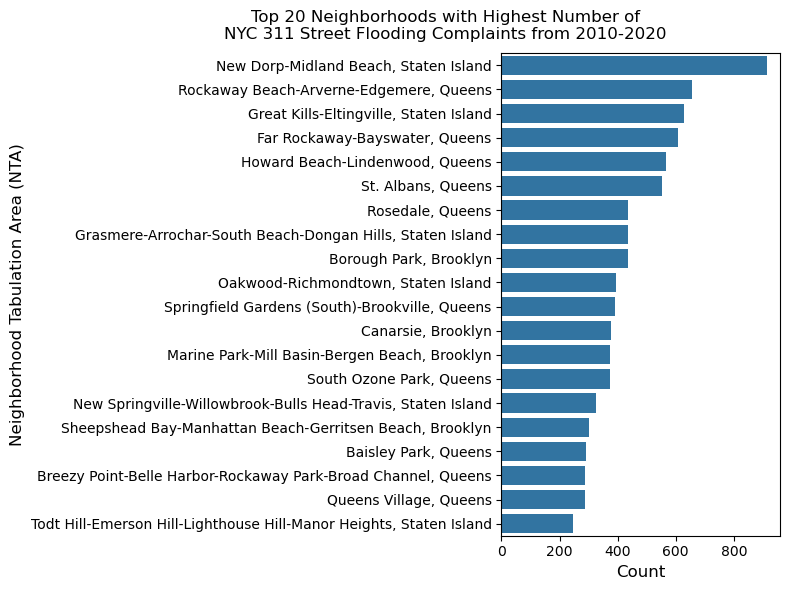

In [33]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count', ascending=False).head(20)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count',
    color='#1f77b4'
)

label = 'Top 20 Neighborhoods with Highest Number of\nNYC 311 Street Flooding Complaints from 2010-2020'
plt.title(label, fontsize=12, pad=10, x=-.2)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)

plt.tight_layout()

**Figure xx:**

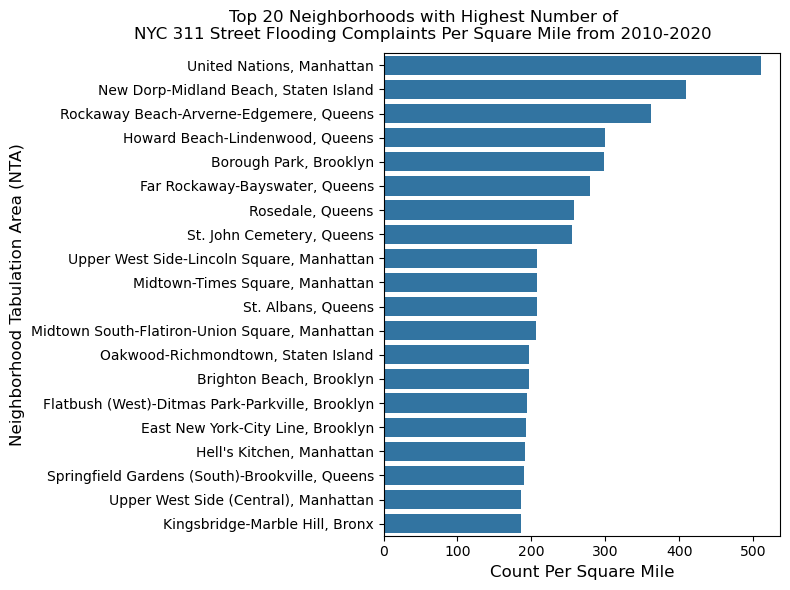

In [34]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count_sq_mi', ascending=False).head(20)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count_sq_mi',
    color='#1f77b4'
)

label = 'Top 20 Neighborhoods with Highest Number of\nNYC 311 Street Flooding Complaints Per Square Mile from 2010-2020'
plt.title(label, fontsize=12, pad=10, x=.1)
plt.xlabel('Count Per Square Mile', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)

plt.tight_layout()

**Figure xx:**

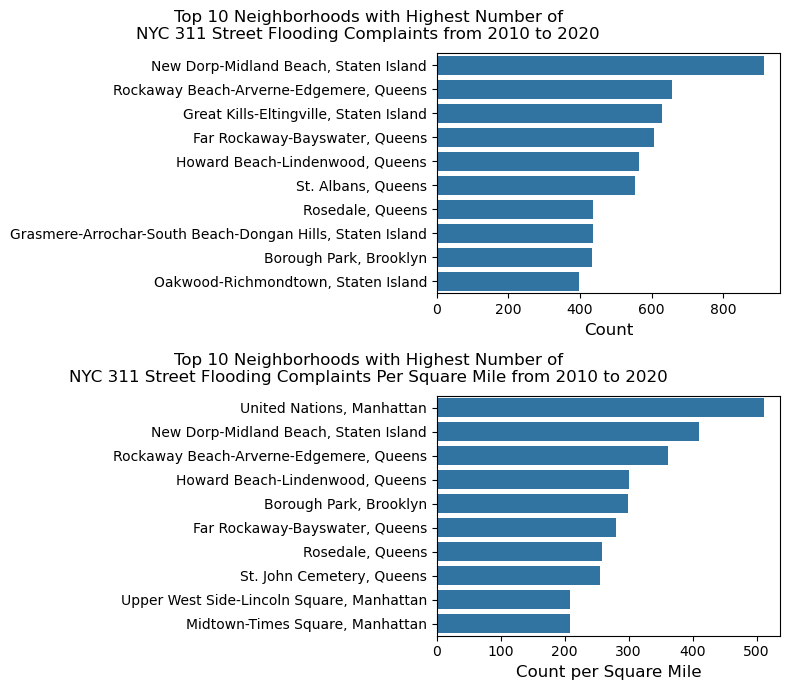

In [35]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 7))

# first plot
data = nta_gdf_counts.sort_values(by='count', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Top 10 Neighborhoods with Highest Number of\n\
NYC 311 Street Flooding Complaints from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10, x=-.2)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('')

# second plot
data = nta_gdf_counts.sort_values(by='count_sq_mi', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count_sq_mi',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Top 10 Neighborhoods with Highest Number of\n\
NYC 311 Street Flooding Complaints Per Square Mile from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10, x=-.2)
axs[1].set_xlabel('Count per Square Mile', fontsize=12)
axs[1].set_ylabel('')

fig.tight_layout()
plt.savefig('figures/counts-nta.png', dpi=250, bbox_inches='tight')

**Figure xx:**

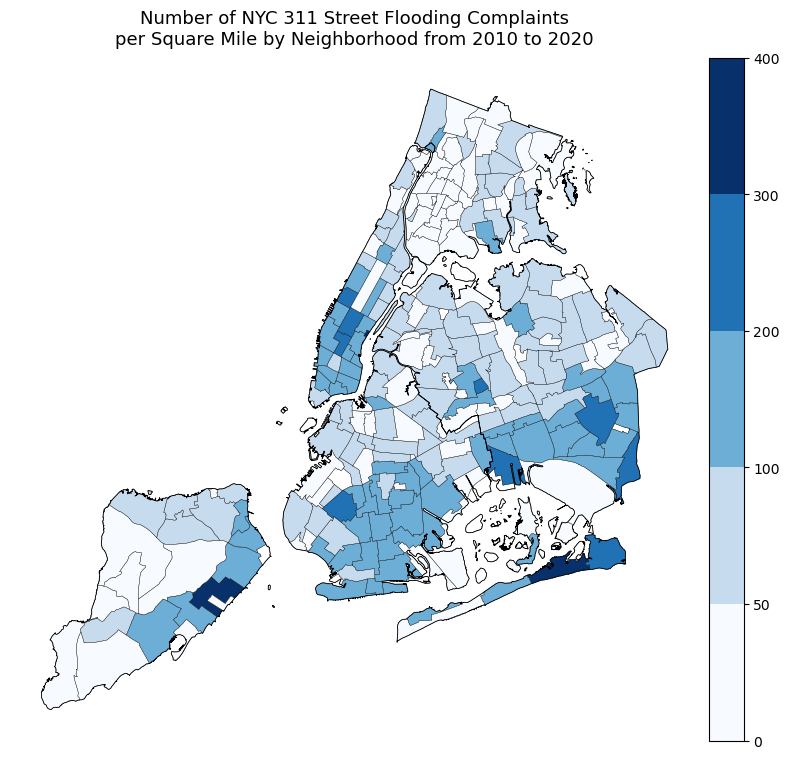

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

nta_gdf_counts.plot(
    column='count_sq_mi', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax,
    zorder=1
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax,
    zorder=2
)

title = 'Number of NYC 311 Street Flooding Complaints\nper Square Mile by Neighborhood from 2010 to 2020'
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png', bbox_inches='tight', dpi=250)

**Figure xx:**

## Counts by Neighborhood Tabulation Areas (NTA) and Year

In [37]:
year_nta = (
    gdf_merged
    .groupby(by=['year', 'ntaname_boro'])['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

year_nta = nta_gdf.merge(
    year_nta, 
    on='ntaname_boro',
    how='left'
)

year_nta = (
    year_nta
    .loc[~year_nta['year'].isnull()]
    .astype({'year':'int'})
    .reset_index(drop=True)
)

year_nta['count'] = year_nta['count'].fillna(0).astype(int)
year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area_sq_mi']).replace(0, np.nan)).round(2)

print(f'shape of data: {year_nta.shape}\n')
year_nta.head()

shape of data: (2028, 17)



,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,ntaname_boro,shape_area_sq_mi,year,count,count_sq_mi
0,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2010,6,4.74
1,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2011,5,3.95
2,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2012,4,3.16
3,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2013,6,4.74
4,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2014,17,13.42


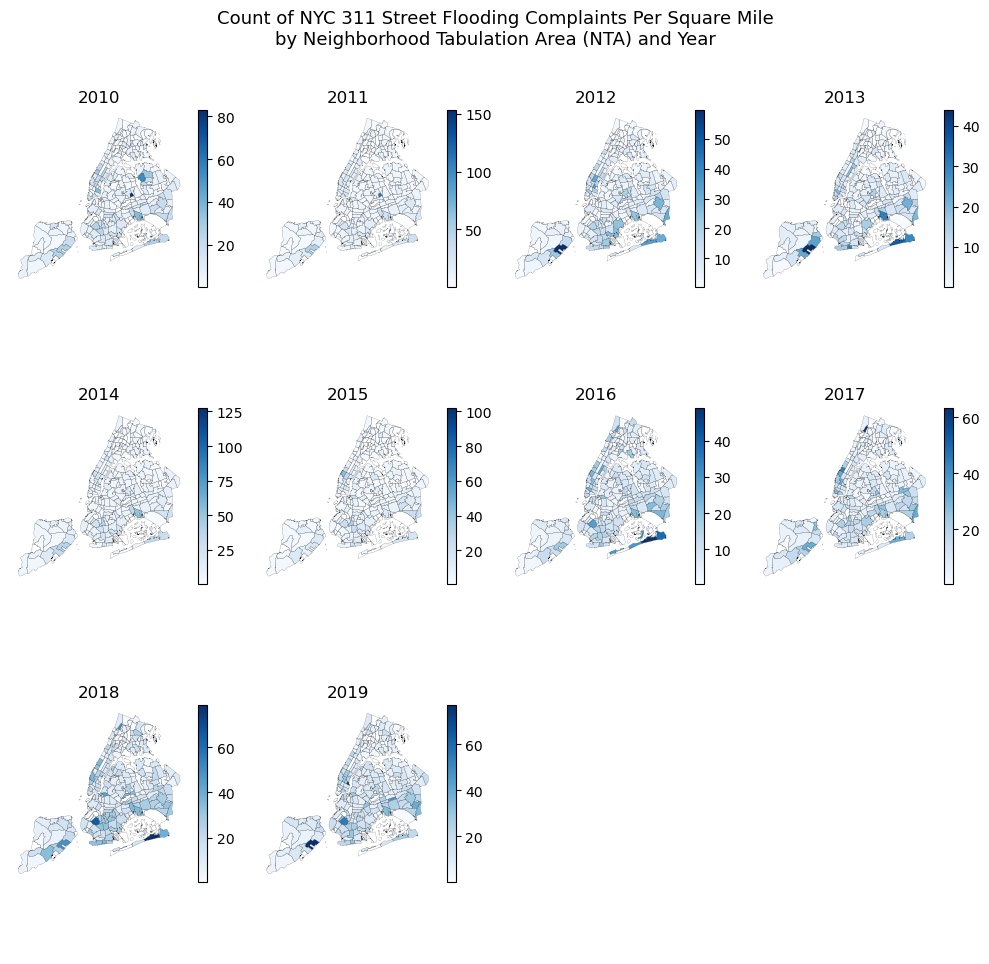

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))

for ax, year in zip(axes.flat, year_nta['year'].unique()):
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    (year_nta
     .loc[year_nta['year'] == year]
     .plot(
         column='count_sq_mi', 
         cmap='Blues',
         legend=True,
         ax=ax, 
         cax=cax)
    )
    
    nta_gdf.plot(
        facecolor="none",
        edgecolor="black",
        linewidth=.09,
        ax=ax
    )
    
    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,2].set_axis_off()
axes[2,3].set_axis_off()

label = 'Count of NYC 311 Street Flooding Complaints Per Square Mile\n\
by Neighborhood Tabulation Area (NTA) and Year'
fig.suptitle(label, y=.96, fontsize=13) 

fig.tight_layout()   

**Figure xx:**


## Timedelta of Complaints Response Time

In [39]:
# calculate complaint close out duration
gdf_merged['complaint_duration'] = gdf_merged['closed_date'] - gdf_merged['created_date']

# preview
gdf_merged.loc[:, ['created_date', 'closed_date', 'complaint_duration']].head(10)

,created_date,closed_date,complaint_duration
0,2016-11-15 09:27:00,2016-11-15 10:05:00,0 days 00:38:00
1,2010-05-04 09:20:00,2010-05-08 09:00:00,3 days 23:40:00
2,2010-07-13 13:20:00,2010-07-13 15:10:00,0 days 01:50:00
3,2010-07-30 11:08:00,2010-07-30 11:20:00,0 days 00:12:00
4,2010-08-09 13:49:00,2010-08-09 14:30:00,0 days 00:41:00
5,2010-12-02 08:03:00,2010-12-02 11:30:00,0 days 03:27:00
6,2010-12-02 09:37:00,2010-12-02 09:37:00,0 days 00:00:00
7,2011-02-17 14:51:00,2011-02-18 11:30:00,0 days 20:39:00
8,2011-03-24 08:58:00,2011-03-24 10:30:00,0 days 01:32:00
9,2011-08-15 11:10:00,2011-08-16 11:50:00,1 days 00:40:00


In [40]:
# retrieve dt values
gdf_merged['complaint_duration_days'] = gdf_merged['complaint_duration'].dt.days
gdf_merged['complaint_duration_seconds'] = gdf_merged['complaint_duration'].dt.seconds
gdf_merged['complaint_duration_hours'] = gdf_merged['complaint_duration_seconds'] / 3600

# examine distribution of complaint duration
cols = ['complaint_duration', 'complaint_duration_days', 'complaint_duration_hours']
gdf_merged.loc[:, cols].describe()

,complaint_duration,complaint_duration_days,complaint_duration_hours
count,24813,24813.000000,24813.000000
mean,2 days 15:23:52.745738121,2.227502,9.937944
std,12 days 20:50:37.070997033,12.842968,8.355478
min,0 days 00:00:00,0.000000,0.000000
25%,0 days 03:05:00,0.000000,1.833333
50%,0 days 17:27:00,0.000000,7.616667
75%,1 days 19:24:00,1.000000,18.283333
max,569 days 16:46:00,569.000000,23.983333


In [41]:
# preview transformations
gdf_merged.iloc[:, -4:]

,complaint_duration,complaint_duration_days,complaint_duration_seconds,complaint_duration_hours
0,0 days 00:38:00,0.0,2280.0,0.633333
1,3 days 23:40:00,3.0,85200.0,23.666667
2,0 days 01:50:00,0.0,6600.0,1.833333
3,0 days 00:12:00,0.0,720.0,0.200000
4,0 days 00:41:00,0.0,2460.0,0.683333
...,...,...,...,...
24809,0 days 00:33:00,0.0,1980.0,0.550000
24810,0 days 23:13:00,0.0,83580.0,23.216667
24811,0 days 22:14:00,0.0,80040.0,22.233333
24812,1 days 20:53:00,1.0,75180.0,20.883333


In [42]:
# calculate median complaint close out duration 
grouped_gdf = (
    gdf_merged
    .groupby('ntaname_boro')['complaint_duration_hours']
    .median()
    .reset_index()
)

# merge to geodataframe to plot
nta_shape_time = nta_gdf.merge(
    grouped_gdf, 
    left_on='ntaname_boro', 
    right_on='ntaname_boro'
)

nta_shape_time.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,ntaname_boro,shape_area_sq_mi,complaint_duration_hours
0,3.532120e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.565312,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((1003059.973 204572.243, 100299...","Greenpoint, Brooklyn",1.266974,2.566667
1,2.885431e+07,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026774,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((995851.880 203199.535, 995969....","Williamsburg, Brooklyn",1.035006,6.450000
2,1.520896e+07,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280416,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((998047.189 196303.521, 998157....","South Williamsburg, Brooklyn",0.545546,6.500000
3,5.226621e+07,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773814,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((1005302.485 199455.944, 100530...","East Williamsburg, Brooklyn",1.874792,9.558333
4,9.982322e+06,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.506134,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((986737.292 194249.956, 986678....","Brooklyn Heights, Brooklyn",0.358067,1.133333


In [43]:
# examine value distributions
nta_shape_time.loc[:, ['complaint_duration_hours']].describe()

,complaint_duration_hours
count,243.000000
mean,7.282922
std,4.299532
min,0.116667
25%,3.666667
50%,6.616667
75%,10.837500
max,22.233333


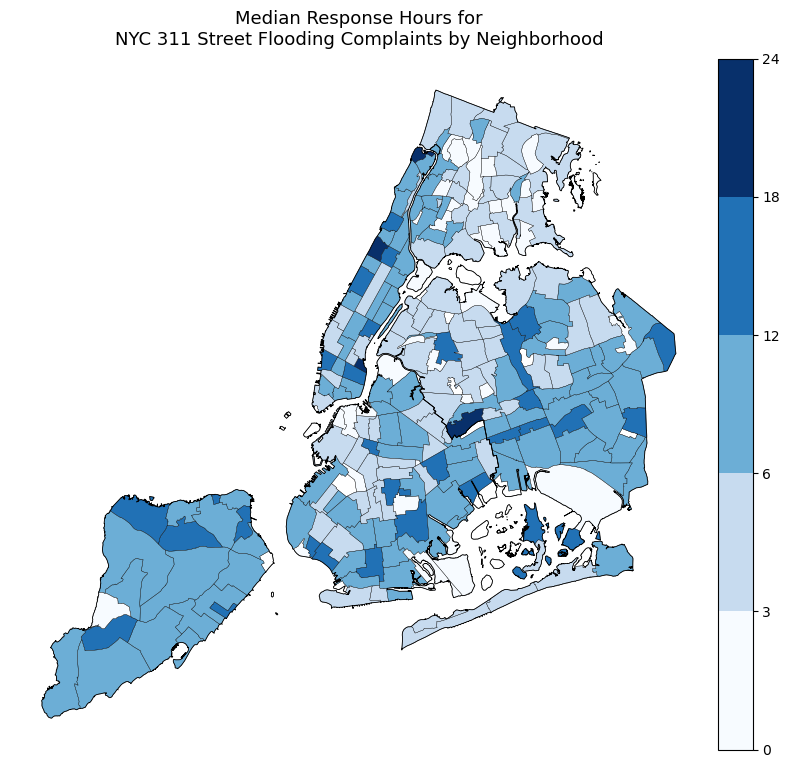

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 3, 6, 12, 18, 24], cmap.N)

nta_shape_time.plot(
    column='complaint_duration_hours', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

title = 'Median Response Hours for\nNYC 311 Street Flooding Complaints by Neighborhood'
ax.set_title(title, fontsize=13, pad=10)
ax.axis('off')

plt.tight_layout()

**Figure xx:**